Речь идет о задаче выбора кредита Tinkoff.ru в рамках соревнования Tinkoff Data Science Challenge. 

Исходная выборка содержит записи о 170746 клиентах, классифицированных на два класса: 0 – клиент не открыл кредитный счет в банке (140690 клиентов) и 1 – клиент открыл кредитный счет в банке (30056 клиентов). Необходимо классифицировать клиентов на тех, кто не откроет кредитного счета, и тех, кто его откроет. По каждому наблюдению (клиенту) фиксируются 15 исходных переменных.

### Список исходных переменных включает в себя:
• категориальный предиктор Идентификационный номер [client_id];

• категориальный предиктор Пол [gender];

• количественный предиктор Возраст [age];

• категориальный предиктор Семейный статус [marital_status];

• категориальный предиктор Сфера занятости [job_position];

• количественный предиктор Сумма кредита [credit_sum];

• количественный предиктор Срок кредитования [credit_month];

• количественный предиктор Внутренняя скоринговая оценка [score_shk];

• категориальный предиктор Образование [education];

• категориальный предиктор Идентификационный номер тарифа [tariff_id];

• количественный предиктор Месячный заработок [monthly_income];

• количественный предиктор Количество кредитов у клиента [credit_count];

• количественный предиктор Количество просроченных кредитов у клиента [overdue_credit_count];

• категориальная зависимая переменная Факт открытия кредитного счета в данном банке [open_account_flg].

In [601]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scikitplot.metrics import plot_confusion_matrix, plot_roc_curve
from scipy import stats

import re
from transliterate import translit
from woe import *

from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

pd.set_option('display.max_rows', 300)
import warnings
warnings.filterwarnings('ignore')

In [602]:
with open('C:\\Users\\Овчинниковы\\Desktop\\tinkoff\\credit_train.csv') as f:
    print(f)

<_io.TextIOWrapper name='C:\\Users\\Овчинниковы\\Desktop\\tinkoff\\credit_train.csv' mode='r' encoding='cp1251'>


In [603]:
train = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\tinkoff\\credit_train.csv', sep=';', encoding='cp1251')
test = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\tinkoff\\credit_test.csv', sep=';', encoding='cp1251')

In [604]:
train.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


In [605]:
print('Размер обучающего набора -', train.shape)
print('Размер тестового набора -', test.shape)

Размер обучающего набора - (170746, 15)
Размер тестового набора - (91940, 14)


In [606]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  object 
 2   age                   170743 non-null  float64
 3   marital_status        170743 non-null  object 
 4   job_position          170746 non-null  object 
 5   credit_sum            170744 non-null  object 
 6   credit_month          170746 non-null  int64  
 7   tariff_id             170746 non-null  float64
 8   score_shk             170739 non-null  object 
 9   education             170741 non-null  object 
 10  living_region         170554 non-null  object 
 11  monthly_income        170741 non-null  float64
 12  credit_count          161516 non-null  float64
 13  overdue_credit_count  161516 non-null  float64
 14  open_account_flg      170746 non-null  int64  
dtype

In [607]:
# Количество дубликатов
train.duplicated().sum()

0

In [608]:
# Удаляем id
train = train.drop('client_id', axis=1)

In [609]:
# Количество дубликатов
train.duplicated().sum()

1145

In [610]:
# Удаляем дубликаты
train.drop_duplicates(inplace=True, ignore_index=True)

In [611]:
# credit_sum, score_shk - отображается как категориальными признаки, являясь количественными.
print('credit_sum -', train['credit_sum'].dtype)
print('score_shk -', train['score_shk'].dtype)

credit_sum - object
score_shk - object


In [612]:
# Преобразовываем. Заменяем разделитель и изменяем тип данных
train.credit_sum = train.credit_sum.str.replace(',', '.').astype(float)
train.score_shk = train.score_shk.str.replace(',', '.').astype(float)

In [613]:
# "tariff_id" - категориальный признак
train.tariff_id = train.tariff_id.astype('str')

In [614]:
# Выделяем целевую переменную и предикторы
target = train.open_account_flg
features = train.drop('open_account_flg', axis=1)

In [615]:
# Категориальные и количественные предикторы
cat_feat = features.select_dtypes(include='object').columns
num_feat = features.select_dtypes(exclude='object').columns

In [616]:
# Смотрим описательные статистики по признакам относительно типа переменной
features[cat_feat].describe()

,gender,marital_status,job_position,tariff_id,education,living_region
count,169601,169598,169601,169601,169596,169412
unique,2,5,18,32,5,301
top,F,MAR,SPC,1.1,SCH,ОБЛ МОСКОВСКАЯ
freq,88098,93313,133719,68897,86991,12125


In [617]:
features[num_feat].describe()

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count
count,169598.000000,169599.000000,169601.000000,169594.000000,169596.000000,160411.000000,160411.000000
mean,36.499800,26077.355613,10.984287,0.469461,40124.994092,2.107324,0.046082
std,10.551539,16227.039254,3.542935,0.124256,25026.029516,1.776482,0.211498
min,18.000000,2736.000000,3.000000,0.000000,5000.000000,0.000000,0.000000
25%,28.000000,14907.000000,10.000000,0.379549,25000.000000,1.000000,0.000000
50%,34.000000,21219.000000,10.000000,0.461599,35000.000000,2.000000,0.000000
75%,43.000000,32028.000000,12.000000,0.552335,50000.000000,3.000000,0.000000
max,71.000000,200000.000000,36.000000,1.128291,950000.000000,21.000000,3.000000


# Категориальные признаки

In [618]:
# Необходимо привести к единому формату место проживания.
features.head(10)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
0,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0
1,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0
2,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0
3,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0
4,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0
5,F,NaN,MAR,SPC,NaN,10,1.1,NaN,SCH,СТАВРОПОЛЬСКИЙ КРАЙ,30000.0,0.0,0.0
6,M,34.0,MAR,SPC,10317.00,6,1.5,NaN,SCH,ОБЛ НИЖЕГОРОДСКАЯ,28000.0,3.0,0.0
7,F,26.0,UNM,SPC,47878.00,10,1.1,0.512525,GRD,МОСКОВСКАЯ ОБЛ,60000.0,3.0,0.0
8,M,23.0,UNM,SPC,37577.16,12,1.6,NaN,SCH,ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА,50000.0,3.0,0.0
9,F,32.0,UNM,SPC,26268.00,10,1.1,0.465026,GRD,КРАЙ СТАВРОПОЛЬСКИЙ,39500.0,7.0,0.0


In [619]:
# Приведем к общему, нижнему регистру
# features.living_region = features.living_region.str.lower()
for i in features[cat_feat]:
    features[i] = features[i].str.lower()
    
features.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
0,m,NaN,NaN,umn,59998.00,10,1.6,NaN,grd,краснодарский край,30000.0,1.0,1.0
1,f,NaN,mar,umn,10889.00,6,1.1,NaN,NaN,москва,NaN,2.0,0.0
2,m,32.0,mar,spc,10728.00,12,1.1,NaN,NaN,обл саратовская,NaN,5.0,0.0
3,f,27.0,NaN,spc,12009.09,12,1.1,NaN,NaN,обл волгоградская,NaN,2.0,0.0
4,m,45.0,NaN,spc,NaN,10,1.1,0.421385,sch,челябинская область,NaN,1.0,0.0


In [620]:
# Общее количество уникальных значений
features.living_region.nunique()

301

In [621]:
# Удаляем лишние символы
features.living_region = features.living_region.str.replace('[().?\|/*]', '')

# Тире после пробелов, чтобы не удалить дефисы.
features.living_region = features.living_region.str.replace(r' -', '')

# Метки города, области, республики
features.living_region = features.living_region.str.replace(r'(^г | г$)', '')
features.living_region = features.living_region.str.replace(r'область|обл|аобл|^ао|ао$', '')
features.living_region = features.living_region.str.replace(r'республика|респ', '')
features.living_region = features.living_region.str.replace(r'автоном(ная|ный)', '')
features.living_region = features.living_region.str.replace('край', '')

# Орфографические или смысловые ошибки
features.living_region = features.living_region.str.replace('аеврейская', 'еврейская')
features.living_region = features.living_region.str.replace('гмосква', 'москва')
features.living_region = features.living_region.str.replace('еврейскаяа', 'еврейская')
features.living_region = features.living_region.str.replace('74', 'челябинская')
features.living_region = features.living_region.str.replace('москвоская', 'московская')
features.living_region = features.living_region.str.replace('годинцово ', '')
features.living_region = features.living_region.str.replace('гусь-хрустальный р-н', 'владимирская')

# Район мы можем отнести ко всей области, а область к краю
features.living_region = features.living_region.str.replace('мытищинский р-н', 'московская')
features.living_region = features.living_region.str.replace('брянский', 'брянская')
features.living_region = features.living_region.str.replace('камчатская', 'камчатский')

# Лишние метки для общего формата
features.living_region = features.living_region.str.replace(r'(сев|северная) осетия', '')
features.living_region = features.living_region.str.replace(r'округ (югра|ю)', '')
features.living_region = features.living_region.str.replace(r'якутия', '')
features.living_region = features.living_region.str.replace(r'чувашия', '')

# Избавляемся от оставшихся пробелов
features.living_region = features.living_region.str.replace(' ', '')

In [622]:
# Редкие категория объединим в одной - "россия"
rare = ['эвенкийский', '98', 'приволжскийфедеральныйокруг', 'дальнийвосток', 'орёл']

for category in rare:
    features.living_region = features.living_region.str.replace(category, 'россия')

In [623]:
features.living_region.nunique()

87

# Пропущенные значения до разбиения

In [624]:
features.isna().sum()[features.isna().sum() > 0]

age                        3
marital_status             3
credit_sum                 2
score_shk                  7
education                  5
living_region            189
monthly_income             5
credit_count            9190
overdue_credit_count    9190
dtype: int64

In [625]:
# Создадим переменную-индикатор пропущенных значений для "credit_count" и он же будет являться индикатором пропущенных
# значений и для "overdue_credit_count".
features['cr_count_and_ovd_na'] = np.where(features.credit_count.isna(), 1, 0)
print(features['cr_count_and_ovd_na'].value_counts())

0    160411
1      9190
Name: cr_count_and_ovd_na, dtype: int64


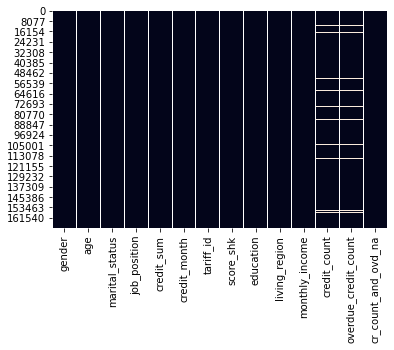

In [626]:
# Видим, что пропущенные значения credit_count и overdue_credit_count идентичны
sns.heatmap(features.isnull(), cbar=False)

In [627]:
# Есть тенденция, по мере увеличения возраста, количество пропущенных значений уменьшается. Это МОЖЕТ говорить нам о том, 
# что молодые люди оставляли пропущенными данные строки в анкетах как признак отсутствия кредита. Соответственно мы можем
# заменить пропущенные значения на нули
features.groupby('age')['credit_count', 'overdue_credit_count'].agg(lambda x: x.isnull().mean())

,credit_count,overdue_credit_count
age,,
18.0,0.933962,0.933962
19.0,0.713287,0.713287
20.0,0.620038,0.620038
21.0,0.521313,0.521313
22.0,0.318156,0.318156
23.0,0.201356,0.201356
24.0,0.134879,0.134879
25.0,0.094506,0.094506
26.0,0.059962,0.059962


In [628]:
# Заменяем на нулевые значения
features.credit_count = features.credit_count.fillna(value=0)
features.overdue_credit_count = features.overdue_credit_count.fillna(value=0)

In [629]:
features.isna().sum()[features.isna().sum() > 0]

age                 3
marital_status      3
credit_sum          2
score_shk           7
education           5
living_region     189
monthly_income      5
dtype: int64

In [630]:
# Пропущенные значения включим в категорию - "россия", так как логично предположить, что клиенты могли просто не указать место 
# жительства.
features.living_region = np.where(features.living_region.isna(), 'россия', features.living_region)
features.living_region.isna().sum()

0

In [631]:
# Транслитерируем кирилицу после заполнения пропущенных значений
features.living_region = features.living_region.apply(lambda x: translit(x, 'ru', reversed=True))
features.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,cr_count_and_ovd_na
0,m,NaN,NaN,umn,59998.00,10,1.6,NaN,grd,krasnodarskij,30000.0,1.0,1.0,0
1,f,NaN,mar,umn,10889.00,6,1.1,NaN,NaN,moskva,NaN,2.0,0.0,0
2,m,32.0,mar,spc,10728.00,12,1.1,NaN,NaN,saratovskaja,NaN,5.0,0.0,0
3,f,27.0,NaN,spc,12009.09,12,1.1,NaN,NaN,volgogradskaja,NaN,2.0,0.0,0
4,m,45.0,NaN,spc,NaN,10,1.1,0.421385,sch,cheljabinskaja,NaN,1.0,0.0,0


# Редкие категории

In [632]:
# Редкие категории, которые можем сделать до разбиения, в предикторе
# livig_region уже укрупнены(в строковом форматировании или с пропущенными значениями)
for i in features.columns:
    print(features[i].value_counts())

f    88098
m    81503
Name: gender, dtype: int64
28.0    7534
29.0    7477
30.0    7271
27.0    7032
26.0    6771
31.0    6716
32.0    6587
33.0    6524
25.0    6116
34.0    5828
35.0    5605
24.0    5390
36.0    5373
37.0    5208
38.0    5099
39.0    4987
40.0    4900
41.0    4576
42.0    4342
23.0    4276
43.0    4038
44.0    3760
22.0    3514
46.0    3201
45.0    3190
47.0    2857
48.0    2610
49.0    2359
50.0    2350
21.0    2346
52.0    1976
51.0    1949
53.0    1920
55.0    1795
54.0    1786
56.0    1527
57.0    1402
58.0    1227
59.0    1061
20.0    1058
60.0     954
61.0     833
62.0     762
63.0     639
64.0     557
65.0     465
19.0     429
66.0     364
67.0     359
68.0     239
69.0     180
70.0     141
18.0     106
71.0      32
Name: age, dtype: int64
mar    93313
unm    51831
div    16835
civ     4167
wid     3452
Name: marital_status, dtype: int64
spc    133719
umn     17591
bis      5549
pna      4090
dir      3727
atp      2778
wrk       653
nor       537
woi       351

In [633]:
# Job_position, tariff_id - имеют редкие категории, которые необходимо обработать заранее. 
# К ним может быть не применима дискретизация, так как редкая категория может быть включена либо только в 
# тренировочный либо только в тестовый набор.
rare_tariff = ['1.26', '1.28', '1.52', '1.27', '1.48', '1.56', '1.96', '1.29']
features.tariff_id = np.where(features.tariff_id.isin(rare_tariff), 'rare', features.tariff_id)

In [634]:
# Функция укрупнения
def freq_change(x: pd.Series, threshold=20):
    frequency = dict(x.value_counts())
    
    for i in frequency:
        if frequency[i] < threshold:
            x = x.replace(i, 'other')
        else:
            pass
    
    return x

In [635]:
# Укрупняем предиктор job_position
features.job_position = freq_change(features.job_position)

# Выбросы

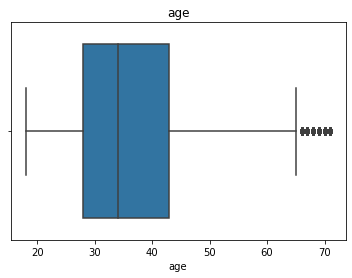

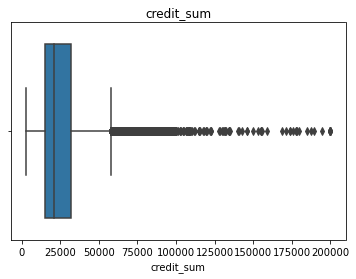

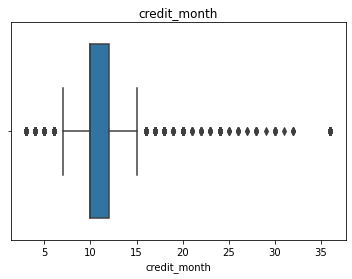

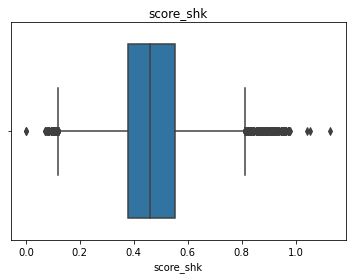

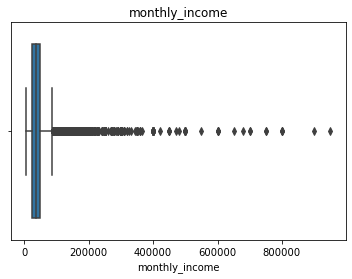

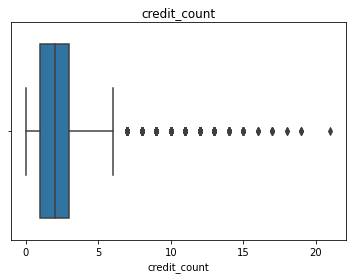

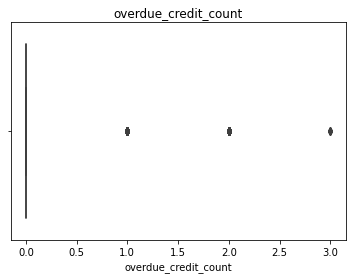

In [636]:
# Имеющиеся выбросы объективной природы. Применим необходимые преобразования в пайплайне
for col in features[num_feat].columns:
    plt.figure()
    plt.title(col)
    sns.boxplot(x=col, data=features)

# Распределение

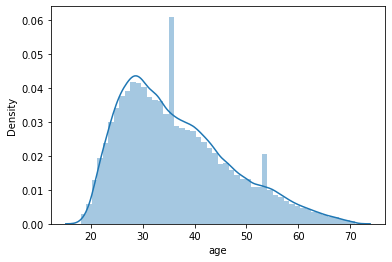

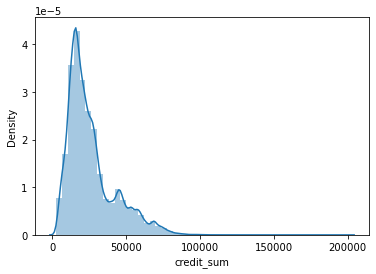

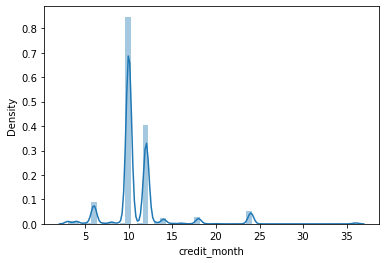

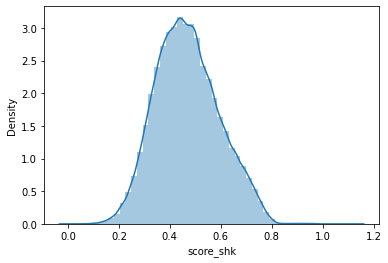

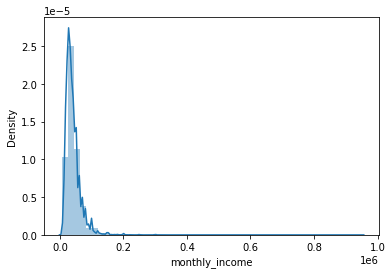

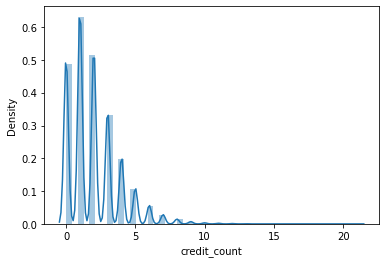

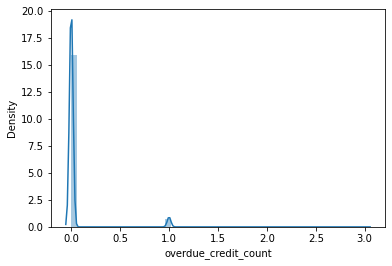

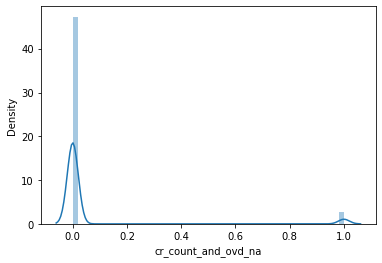

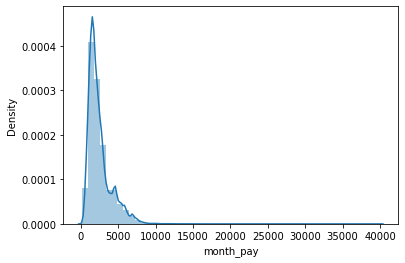

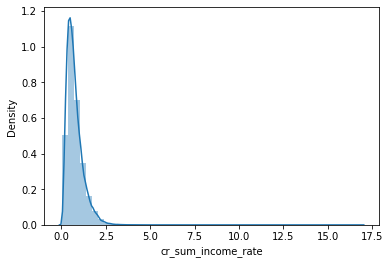

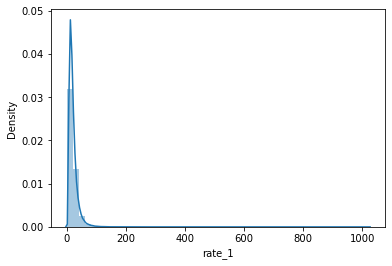

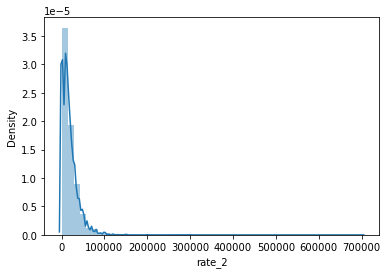

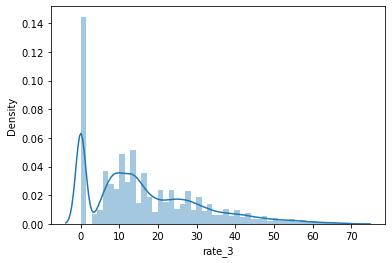

In [668]:
for i in num_feat:
    plt.figure()
    sns.distplot(features[i])

# Feature Engineering

In [637]:
# Меняем признаки с числовых на категориальные и сразу обрабатываем редкие категории
features['cat_overdue_cc'] = np.where(features.overdue_credit_count == 3.0, 2.0, features.overdue_credit_count).astype('str')
features['cat_credit_count'] = np.clip(features.credit_count, a_min=0.0, a_max=15.0).astype('str')

In [638]:
# До разбиения соединим категориальные переменные
features['gen_mar'] = features['gender'] + '_' + features['marital_status']
features['gen_edu'] = features['gender'] + '_' + features['education']
features['job_edu'] = features['job_position'] + '_' + features['education']

In [639]:
# В job_edu есть редкие категории, которые так же необходимо обработать до разбиения на обучающую и тестовую выборки
for i in features[['gen_mar', 'gen_edu', 'job_edu']].columns:
    print(features[i].value_counts())

m_mar    48796
f_mar    44517
f_unm    26310
m_unm    25521
f_div    11611
m_div     5224
f_wid     3171
f_civ     2488
m_civ     1679
m_wid      281
Name: gen_mar, dtype: int64
m_sch    44511
f_sch    42480
f_grd    40581
m_grd    31466
m_ugr     5149
f_ugr     4741
m_pgr      306
f_pgr      255
m_acd       70
f_acd       37
Name: gen_edu, dtype: int64
spc_sch      71597
spc_grd      53786
umn_grd      10893
spc_ugr       7985
umn_sch       5628
pna_sch       3105
dir_grd       2754
bis_grd       2643
bis_sch       2620
atp_sch       2116
pna_grd        923
umn_ugr        892
dir_sch        711
atp_grd        461
wrk_sch        443
spc_pgr        295
nor_sch        287
bis_ugr        254
atp_ugr        193
dir_ugr        193
nor_grd        179
woi_sch        176
umn_pgr        152
wrk_grd        122
inp_sch        117
inp_grd         89
woi_ugr         88
woi_grd         84
wrk_ugr         84
nor_ugr         63
dir_pgr         57
biu_sch         57
pna_ugr         53
wrp_sch         5

In [640]:
# Применяем ранее написанную функцию
features.job_edu = freq_change(features.job_edu)

In [641]:
#  - [сумма кредита / количество месяцев кредитования]
features['month_pay'] = features['credit_sum'] / features['credit_month']

#  - [сумма кредита / ежемесячный доход]
features['cr_sum_income_rate'] = features['credit_sum'] / features['monthly_income']

#  - [ежемесячный доход * количество месяцев кредитования / сумму кредитования]
features['rate_1'] = (features['monthly_income'] * features['credit_month']) / features['credit_sum']

#  - [отношение ежемесячного дохода к количеству кредитов]
features['rate_2'] = round(features['monthly_income'] / features['credit_count'], 0)

#  - [отношение возраста к количеству кредитов]
features['rate_3'] = round(features['age'] / features['credit_count'], 0)

In [642]:
# В связи с делением на 0 получили inf-значения.(Как пример решения данной проблемы, заменить inf на 0)
features = features.replace(np.inf, 0)

# Разбиение

In [643]:
x_train, x_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=.3, random_state=32)

In [644]:
# Список категориальных и количественных предикторов создаем заново, так как мы генерировали новые признаки
cat_feat = x_train.select_dtypes(include='object').columns.tolist()
num_feat = x_train.select_dtypes(exclude='object').columns.tolist()
age_bins_feat = ['age']
cr_sum_bins_feat = ['credit_sum']

# Классы

In [645]:
## Класс укрупнения по порогу
class ClassGrouper(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.0001):
        self.threshold = threshold
        self.categories = {}
        self.numpy_data = pd.DataFrame()
        
        
    def fit(self, x, y=None):
                
        if isinstance(x, pd.DataFrame):
            for col in x.columns:
                if x[col].dtype != 'object':
                    raise TypeError('Data type is not "object". "int" or "float" is unsupported data type.')
                else:
                    pass

            for col in x.columns:
                frequency = x[col].value_counts()/len(x)
                self.categories[col] = frequency[frequency >= self.threshold].index.tolist()
        else:
            for col in range(x.shape[1]):
                if x[col].dtype != 'object':
                    raise TypeError('Data type is not "object". "int" or "float" is unsupported data type.')
                else:
                    pass

            for col in range(x.shape[1]):
                self.numpy_data[col] = x[:, col]
                frequency = self.numpy_data[col].value_counts()/len(x)
                self.categories[col] = frequency[frequency >= self.threshold].index.tolist()
        return self
    
    
    def transform(self, x):
        x = x.copy()
        
        if isinstance(x, pd.DataFrame):
            for col in x.columns:
                x[col] = np.where(x[col].isin(self.categories[col]), x[col], 'other')
            return x
        else:
            for col in self.numpy_data.columns:
                self.numpy_data[col] = np.where(self.numpy_data[col].isin(self.categories[col]), self.numpy_data[col], 'other')
            return self.numpy_data
        

In [646]:
class Binning(BaseEstimator, TransformerMixin):
    
    def __init__(self, bins=[-np.inf, 23, 30, 50, np.inf]):
        self.bins = bins
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        bins = np.array(self.bins)
        bin_x = np.digitize(x, bins)
        return bin_x

In [647]:
# class CrSumBinning(BaseEstimator, TransformerMixin):
    
#     def __init__(self, bins=[-np.inf, 10000, 30000, 50000, np.inf]):
#         self.bins = bins
        
#     def fit(self, x, y=None):
#         return self
    
#     def transform(self, x):
#         bins = np.array(self.bins)
#         bin_x = np.digitize(x, bins)
#         return bin_x

In [648]:
# Для приведения к нормальному распределению нам необходимо избавиться от отрицательных и нулевых значений.
class ClippingNum(BaseEstimator, TransformerMixin):
    """
    Замена отрицательных и нулевых значений положительными близкими к нулю значениями
    """
    def __init__(self, value=0.01):
        self.value = value
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        positive_x = np.where(x <= 0, self.value, x)
        return positive_x

In [649]:
# Пайпы для разных типов данных
num_pipe = Pipeline([
                    ('imputer', SimpleImputer()),
                    ('clip', ClippingNum()),
                    ('power', PowerTransformer())
])

cat_pipe = Pipeline([
                    ('rarecat', ClassGrouper()),
                    ('imputer', SimpleImputer()),
                    ('ohe', OneHotEncoder(sparse=False))
])

age_bins_pipe = Pipeline([
                    ('imp', SimpleImputer()),
                    ('binning', Binning()),
                    ('ohe', OneHotEncoder(sparse=False))
])

cr_sum_bins_pipe = Pipeline([
                    ('imp', SimpleImputer()),
                    ('binning', Binning()),
                    ('ohe', OneHotEncoder(sparse=False))
])

transformers_list = [
                    ('num', num_pipe, num_feat),
                    ('cat', cat_pipe, cat_feat),
                    ('age_bin', age_bins_pipe, age_bins_feat),
                    ('cr_sum_bin', cr_sum_bins_pipe, cr_sum_bins_feat)
]

In [650]:
transformer = ColumnTransformer(transformers=transformers_list, remainder='drop', n_jobs=-1)

In [651]:
ml_pipe = Pipeline([
                    ('tf', transformer),
                    ('log_reg', LogisticRegression(random_state=32, n_jobs=-1))
])


# param_grid = {
#             'tf__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
#             'tf__cat__rarecat__threshold': [0.0001, 0.001],
#             'tf__cat__imputer__strategy': ['most_frequent'],
#             'tf__cat__ohe__drop': ['first'],
#             'log_reg__C': [0.8, 0.5],
#             'log_reg__max_iter': [100, 200, 300]
# }


b_params = {
            'log_reg__C': [10],
            'log_reg__max_iter': [300],
            'tf__cat__imputer__strategy': ['most_frequent'],
            'tf__cat__ohe__drop': ['first'],
            'tf__cat__rarecat__threshold': [0.0001],
            'tf__cr_sum_bin__binning__bins': [[-np.inf, 10000, 30000, 50000, np.inf]],
            'tf__num__imputer__strategy': ['most_frequent']
}

# Обучение модели

In [652]:
%%time
gs = GridSearchCV(ml_pipe, param_grid=b_params, scoring='roc_auc', cv=5).fit(x_train, y_train)

Wall time: 25min 56s


In [653]:
gs.score(x_test, y_test)

0.7315771024563853

In [654]:
# ROC-AUC
y_proba = gs.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:, 1])

0.7315771024563853

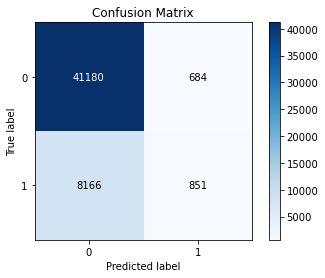

In [655]:
# Confusion matrix.
y_pred = gs.predict(x_test)
plot_confusion_matrix(y_test, y_pred)

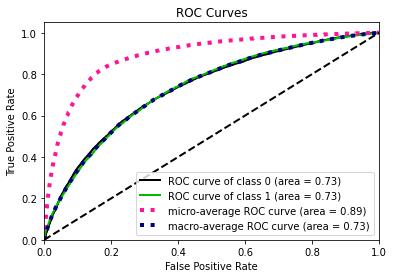

In [656]:
plot_roc_curve(y_test, y_proba)

### Коэффициенты

In [659]:
# Получаем доступ к категориальным данным
cat = gs.best_estimator_['tf'].named_transformers_['cat']

# Получаем имена категориальных признаков, они были обработаны OneHotEncoding
ohe_columns = list(cat.named_steps['ohe'].get_feature_names(input_features=cat_feat))

# Получаем доступ к категориальным данным, к которым был применен биннинг и были обработаны OneHotEncoding
age_bin = gs.best_estimator_['tf'].named_transformers_['age_bin']
age_bin_columns = list(bin_f.named_steps['ohe'].get_feature_names(input_features=age_bins_feat))

cr_sum_bin = gs.best_estimator_['tf'].named_transformers_['cr_sum_bin']
cr_sum_bin_columns = list(bin_f.named_steps['ohe'].get_feature_names(input_features=cr_sum_bins_feat))

# Итоговое количество признаков
all_feat = num_feat + ohe_columns + age_bin_columns + cr_sum_bin_columns
len(all_feat)

237

In [660]:
# Константа
intercept = np.round(gs.best_estimator_['log_reg'].intercept_.item(), 3)

# Округляем коэффициенты до двух знаков после запятой
coefs = np.round(gs.best_estimator_['log_reg'].coef_, 2)

# Коэффициенты и процентное увеличение или уменьшение шансов на одобрение открытия счета
coef_const = list(zip(coefs[0], all_feat))
coef_const.sort(reverse=True)
const_res = pd.DataFrame(
                        coef_const, columns=['coef', 'feature_name']).pivot_table(
                        index='feature_name', values='coef').sort_values(by='coef', ascending=False).reset_index()

const_res['percentage'] = (np.exp(const_res['coef']) - 1) * 100
const_res

,feature_name,coef,percentage
0,tariff_id_1.18,5.59,26673.561971
1,month_pay,3.16,2257.059593
2,living_region_chukotskij,3.07,2054.190268
3,living_region_ingushetija,2.22,820.733087
4,tariff_id_1.32,2.15,758.485840
5,tariff_id_1.91,1.71,452.896148
6,credit_month,1.71,452.896148
7,tariff_id_1.25,1.53,361.817682
8,tariff_id_1.3,1.45,326.311452
9,living_region_dagestan,1.38,297.490163
